In [57]:
import sys
sys.executable

'C:\\Users\\SEAN\\anaconda3\\envs\\ANN_Assignment\\python.exe'

In [129]:
# pip install termcolor

In [135]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, classification_report, precision_recall_curve, f1_score, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter  # Import SummaryWriter from torch.utils.tensorboard
from torch.utils.data import DataLoader, TensorDataset, random_split

from termcolor import colored
import time

In [60]:
df = pd.read_csv("Employee.csv")
df

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


### **About Dataset**

##### *This dataset contains information about employees in a company, including their educational backgrounds, work history, demographics, and employment-related factors.*
1. **Education:** The educational qualifications of employees, including degree, institution, and field of study.
2. **Joining Year:** The year each employee joined the company, indicating their length of service.
3. **City:** The location or city where each employee is based or works.
4. **Payment Tier:** Categorization of employees into different salary tiers.
5. **Age:** The age of each employee, providing demographic insights.
6. **Gender:** Gender identity of employees, promoting diversity analysis.
7. **Ever Benched:** Indicates if an employee has ever been temporarily without assigned work.
8. **Experience in Current Domain:** The number of years of experience employees have in their current field.
9. **Leave or Not:** a target column **(1=>Leave, 0=>Not)**

In [61]:
# Listing unique values in each Feature variables
for column in df.columns:
    print(f"{column}: {df[column].unique()}")

Education: ['Bachelors' 'Masters' 'PHD']
JoiningYear: [2017 2013 2014 2016 2015 2012 2018]
City: ['Bangalore' 'Pune' 'New Delhi']
PaymentTier: [3 1 2]
Age: [34 28 38 27 24 22 23 37 32 39 29 30 36 31 25 26 40 35 33 41]
Gender: ['Male' 'Female']
EverBenched: ['No' 'Yes']
ExperienceInCurrentDomain: [0 3 2 5 1 4 7 6]
LeaveOrNot: [0 1]


In [62]:
# Describe the Dataset
df.describe()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,2.698259,29.393295,2.905652,0.343864
std,1.863377,0.561435,4.826087,1.558240,0.475047
min,2012.000000,1.000000,22.000000,0.000000,0.000000
25%,2013.000000,3.000000,26.000000,2.000000,0.000000
50%,2015.000000,3.000000,28.000000,3.000000,0.000000
75%,2017.000000,3.000000,32.000000,4.000000,1.000000
max,2018.000000,3.000000,41.000000,7.000000,1.000000


### **Step 1: Data Cleaning**

In [63]:
# Listing out the missing/null values in each Feature variable.
df.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

> ****Note:*** The dataset itself doesn't have any missing/null values. Even if it has any, we simply remove/drop those rows from the dataset because we have a very large number of data and removing/droping those data didn't cause much effect on developing ANN models.*

### **Step 2: Data Transformation**

In [64]:
# Probalility Distribution for each Quantitative features
df_numeric_columns = df.select_dtypes(include=['float', 'int']).columns

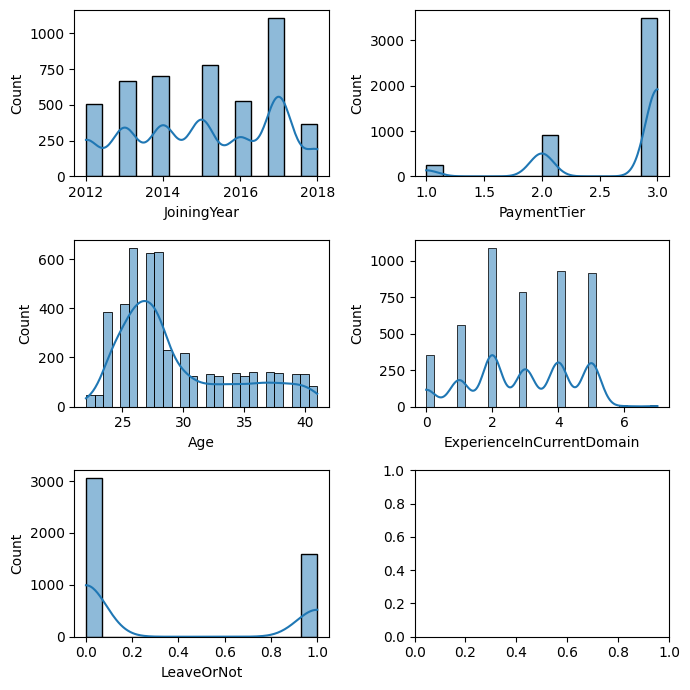

In [65]:
fig, axes = plt.subplots(nrows=(len(df_numeric_columns) + 1) // 2, ncols=2, figsize=(7, 7))
axes = axes.flatten()

# Plot each column
for i, column in enumerate(df_numeric_columns):
    sns.histplot(data=df, x=column, ax=axes[i], kde=True)
    # axes[i].set_title(f"Distribution of {column}")

plt.tight_layout()
plt.show()

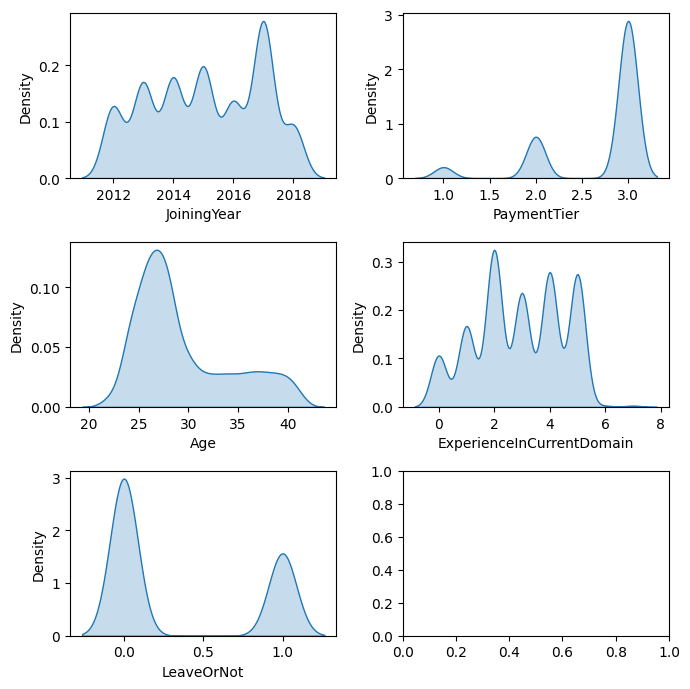

In [66]:
fig, axes = plt.subplots(nrows=(len(df_numeric_columns) + 1) // 2, ncols=2, figsize=(7, 7))
axes = axes.flatten()

# Plot each column
for i, column in enumerate(df_numeric_columns):
    sns.kdeplot(data=df, x=column, ax=axes[i], fill=True)
    # axes[i].set_title(f"Distribution of {column}")

plt.tight_layout()
plt.show()

> ****Note:*** In (ANNs), we do not perform transformations aimed at converting skewed distributions into Gaussian or normal distributions. Such transformations can inadvertently introduce data leakage, as they may involve information from the entire dataset.*

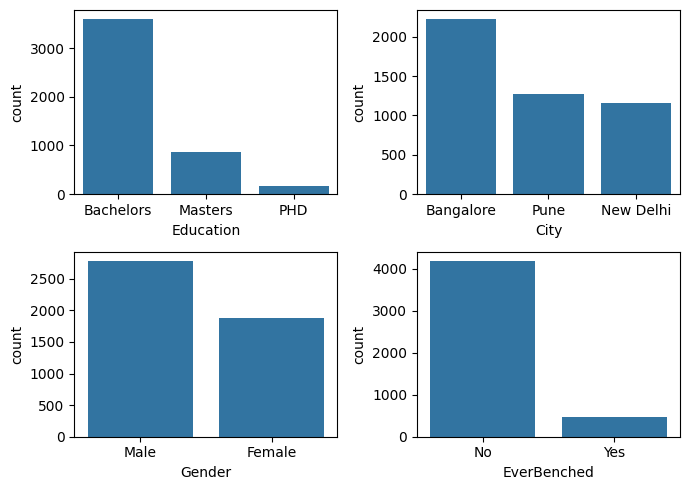

In [67]:
# CountPlot for each Qualitative features
df_non_numeric_columns = df.select_dtypes(include=['object', 'category']).columns
fig, axes = plt.subplots(nrows=(len(df_non_numeric_columns) + 1) // 2, ncols=2, figsize=(7, 5))
axes = axes.flatten()

# Plot each column
for i, column in enumerate(df_non_numeric_columns):
    sns.countplot(data=df, x=column, ax=axes[i], fill=True)

plt.tight_layout()
plt.show()

### **Step 3: Data Encoding**

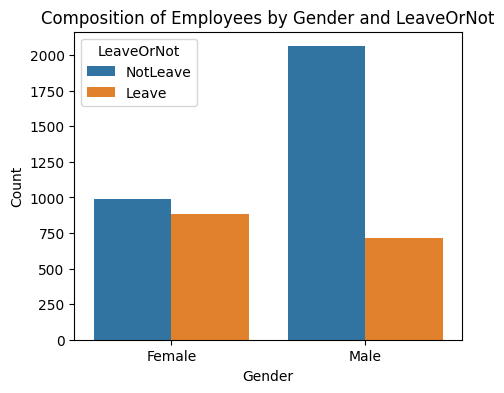

In [68]:
# Analysis of "Gender" Feature variable encoding technique

# Two way frequency tab
df_twoway = pd.crosstab(index=df['Gender'], columns=df['LeaveOrNot'], margins=False).reset_index()
df_twoway = df_twoway.rename(columns={0: 'NotLeave', 1: 'Leave'})

# Reshape the twoway DataFrame
df_gender = pd.melt(df_twoway, id_vars="Gender", var_name="LeaveOrNot", value_name="Count")

plt.figure(figsize=(5, 4))
sns.barplot(x='Gender', y='Count', hue='LeaveOrNot', data=df_gender)
plt.ylabel("Count")
plt.title("Composition of Employees by Gender and LeaveOrNot")
plt.show()

> ***Note:*** **-1 => Male, 0 => Female** to encode the gender feature. This reflects and align with observed behavior patterns in the analysis. **Males are less likely to leave**, while **females exhibit an equal likelihood of leaving and not leaving.**

In [69]:
# Gender feature encoding
gender_mapping = {'Male': -1, 'Female': 0}
df['Gender'] = df['Gender'].map(gender_mapping)

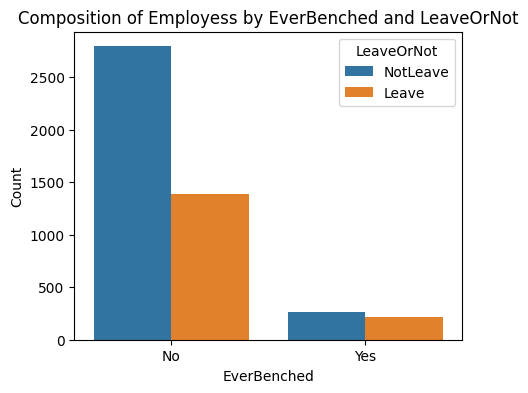

In [70]:
# Analysis of "EverBenched" Feature variable encoding technique

# Two way frequency tab
df_twoway = pd.crosstab(index=df['EverBenched'], columns=df['LeaveOrNot'], margins=False).reset_index()
df_twoway = df_twoway.rename(columns={0: 'NotLeave', 1: 'Leave'})

# Reshape the twoway DataFrame
df_benched = pd.melt(df_twoway, id_vars="EverBenched", var_name="LeaveOrNot", value_name="Count")

plt.figure(figsize=(5, 4))
sns.barplot(x='EverBenched', y='Count', hue='LeaveOrNot', data=df_benched)
plt.ylabel("Count")
plt.title("Composition of Employess by EverBenched and LeaveOrNot")
plt.show()

> ***Note:*** ***-1 => No, 0 => Yes** to encode the EverBenched feature. This reflects and align with observed behavior patterns in the analysis. **NotBenched employee are less likely to leave**, while **Benched have an equal likelihood of leaving and not leaving***

In [71]:
# EverBenched feature encoding
everBenched_mapping = {'No': -1, 'Yes': 0}
df['EverBenched'] = df['EverBenched'].map(everBenched_mapping)

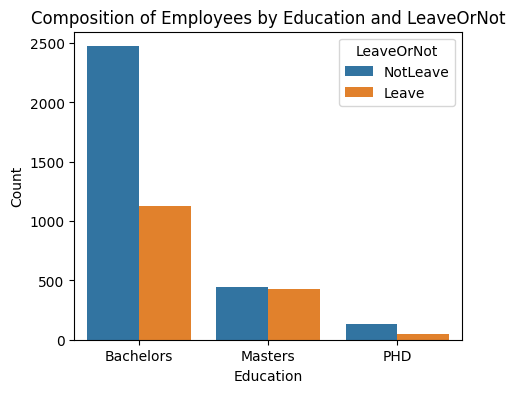

In [72]:
# Analysis of "Education" Feature variable encoding technique

# Two way frequency tab
df_twoway = pd.crosstab(index=df['Education'], columns=df['LeaveOrNot'], margins=False).reset_index()
df_twoway = df_twoway.rename(columns={0: 'NotLeave', 1: 'Leave'})

# Reshape the twoway DataFrame
df_education = pd.melt(df_twoway, id_vars="Education", var_name="LeaveOrNot", value_name="Count")

plt.figure(figsize=(5, 4))
sns.barplot(x='Education', y='Count', hue='LeaveOrNot', data=df_education)
plt.ylabel("Count")
plt.title("Composition of Employees by Education and LeaveOrNot")
plt.show()

> ***Note:*** ***-1 => Bachelors, 0 => Masters&PHD** to encode the Education feature. This reflects and align with observed behavior patterns in the analysis. **Bachelors are less likely to leave**, while **Both  Masters&PHD have an equal likelihood of leaving and not leaving**, So here rather than considering Masters&PHD as seperate categories we can make them as a same category under **HigherStudy**. The few values in the **PHD** also might lead the model to overfit rather than learning the **Base Pattern***

In [73]:
# EverBenched feature encoding
education_mapping = {'Bachelors': -1, 'Masters': 0, 'PHD': 0}
df['Education'] = df['Education'].map(education_mapping)

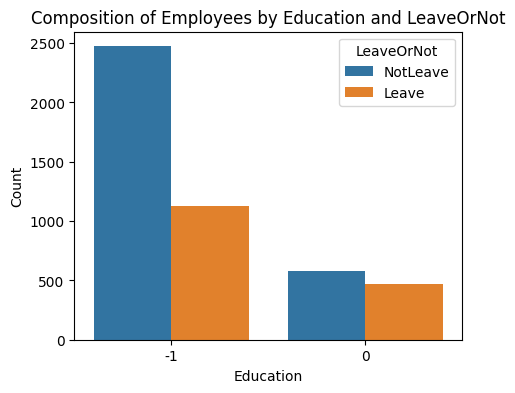

In [74]:
# Viewing the Education feature variable after applying the above encoding

# Two way frequency tab
df_twoway = pd.crosstab(index=df['Education'], columns=df['LeaveOrNot'], margins=False).reset_index()
df_twoway = df_twoway.rename(columns={0: 'NotLeave', 1: 'Leave'})

# Reshape the twoway DataFrame
df_education = pd.melt(df_twoway, id_vars="Education", var_name="LeaveOrNot", value_name="Count")

plt.figure(figsize=(5, 4))
sns.barplot(x='Education', y='Count', hue='LeaveOrNot', data=df_education)
plt.ylabel("Count")
plt.title("Composition of Employees by Education and LeaveOrNot")
plt.show()

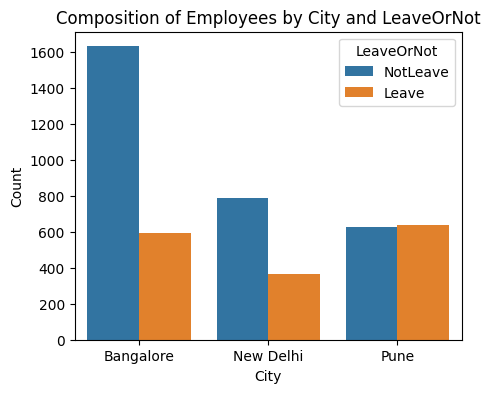

In [75]:
# Analysis of "City" Feature variable encoding technique

# Two way frequency tab
df_twoway = pd.crosstab(index=df['City'], columns=df['LeaveOrNot'], margins=False).reset_index()
df_twoway = df_twoway.rename(columns={0: 'NotLeave', 1: 'Leave'})

# Reshape the twoway DataFrame
df_city = pd.melt(df_twoway, id_vars="City", var_name="LeaveOrNot", value_name="Count")

plt.figure(figsize=(5, 4))
sns.barplot(x='City', y='Count', hue='LeaveOrNot', data=df_city)
plt.ylabel("Count")
plt.title("Composition of Employees by City and LeaveOrNot")
plt.show()

>  ***Note:** Since the data for each city (Bangalore, New Delhi, Pune) is significant and there is no inherent ordering with the target variable, One Hot Encoding is an appropriate choice for encoding the **City** feature.*

In [76]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Set sparse_output to False for dense array
encoded = encoder.fit_transform(df[['City']])

# Convert to DataFrame
df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['City']))
# Concatenate with the original DataFrame
df = pd.concat([df, df_encoded], axis=1)
# Optionally drop the original column
df = df.drop('City', axis=1)
df

,Education,JoiningYear,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,City_Bangalore,City_New Delhi,City_Pune
0,-1,2017,3,34,-1,-1,0,0,1.0,0.0,0.0
1,-1,2013,1,28,0,-1,3,1,0.0,0.0,1.0
2,-1,2014,3,38,0,-1,2,0,0.0,1.0,0.0
3,0,2016,3,27,-1,-1,5,1,1.0,0.0,0.0
4,0,2017,3,24,-1,0,2,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4648,-1,2013,3,26,0,-1,4,0,1.0,0.0,0.0
4649,0,2013,2,37,-1,-1,2,1,0.0,0.0,1.0
4650,0,2018,3,27,-1,-1,5,1,0.0,1.0,0.0
4651,-1,2012,3,30,-1,0,2,0,1.0,0.0,0.0


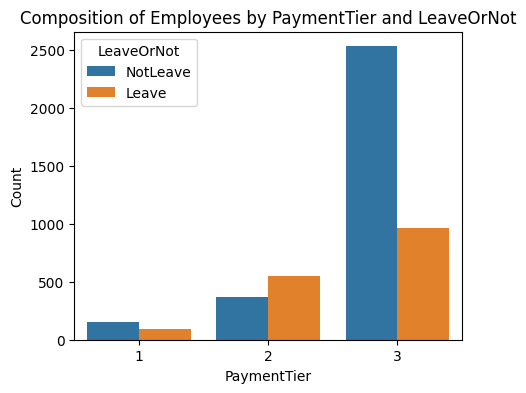

In [77]:
# Analysis of "PaymentTier" Feature variable encoding technique

# Two way frequency tab'
df_twoway = pd.crosstab(index=df['PaymentTier'], columns=df['LeaveOrNot'], margins=False).reset_index()
df_twoway = df_twoway.rename(columns={0: 'NotLeave', 1: 'Leave'})

# Reshape the twoway DataFrame
df_paymentTier = pd.melt(df_twoway, id_vars="PaymentTier", var_name="LeaveOrNot", value_name="Count")

plt.figure(figsize=(5, 4))
sns.barplot(x='PaymentTier', y='Count', hue='LeaveOrNot', data=df_paymentTier)
plt.ylabel("Count")
plt.title("Composition of Employees by PaymentTier and LeaveOrNot")
plt.show()

>  ***Note:** As there is a clear ordering in the PaymentTier feature with respect to the target variable (employees in PaymentTier 3 are less likely to leave), we retain the data as-is, as it already reflects the inherent order.*

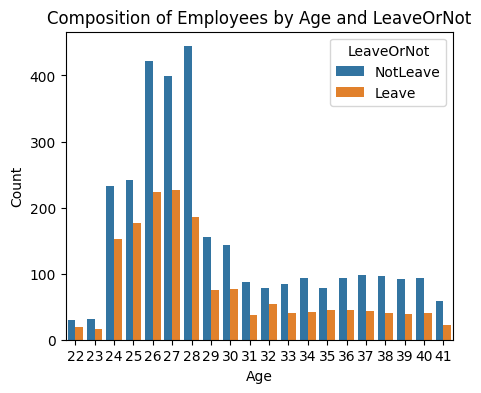

In [78]:
# Analysis of "Age" Feature variable encoding technique

# Two way frequency tab'
df_twoway = pd.crosstab(index=df['Age'], columns=df['LeaveOrNot'], margins=False).reset_index()
df_twoway = df_twoway.rename(columns={0: 'NotLeave', 1: 'Leave'})

# Reshape the twoway DataFrame
df_age = pd.melt(df_twoway, id_vars="Age", var_name="LeaveOrNot", value_name="Count")

plt.figure(figsize=(5, 4))
sns.barplot(x='Age', y='Count', hue='LeaveOrNot', data=df_age)
plt.ylabel("Count")
plt.title("Composition of Employees by Age and LeaveOrNot")
plt.show()

***Note:** Since the **Age** feature follows a **right-skewed distribution** and shows no direct significant relationship with the target variable, we specifically apply **Kmeans clustering** for discretizing group ages into **3 bins**. This helps reduce potential noise and improve the model's ability to generalize, especially when age doesn't provide additional predictive value directly.*

In [79]:
# Number of bins (clusters)
n_bins = 3  # Change this based on your requirements

# Reshape the feature to 2D array for KMeans
age_reshaped = np.array(df['Age']).reshape(-1, 1)

# Apply K-Means
kmeans = KMeans(n_clusters=n_bins, random_state=42)
df['Age_Bin'] = kmeans.fit_predict(age_reshaped)

# Sort bins by the cluster centers for better interpretability
bin_centers = kmeans.cluster_centers_.flatten()
sorted_bins = np.argsort(bin_centers)

# Map sorted bin indices to the original bin values
bin_mapping = {original: sorted_idx for sorted_idx, original in enumerate(sorted_bins)}
df['Age_Bin'] = df['Age_Bin'].map(bin_mapping)

C:\Users\SEAN\AppData\Local\Temp\ipykernel_12588\1762819344.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(title='Age Bin', bbox_to_anchor=(1.05, 1), loc='upper left')


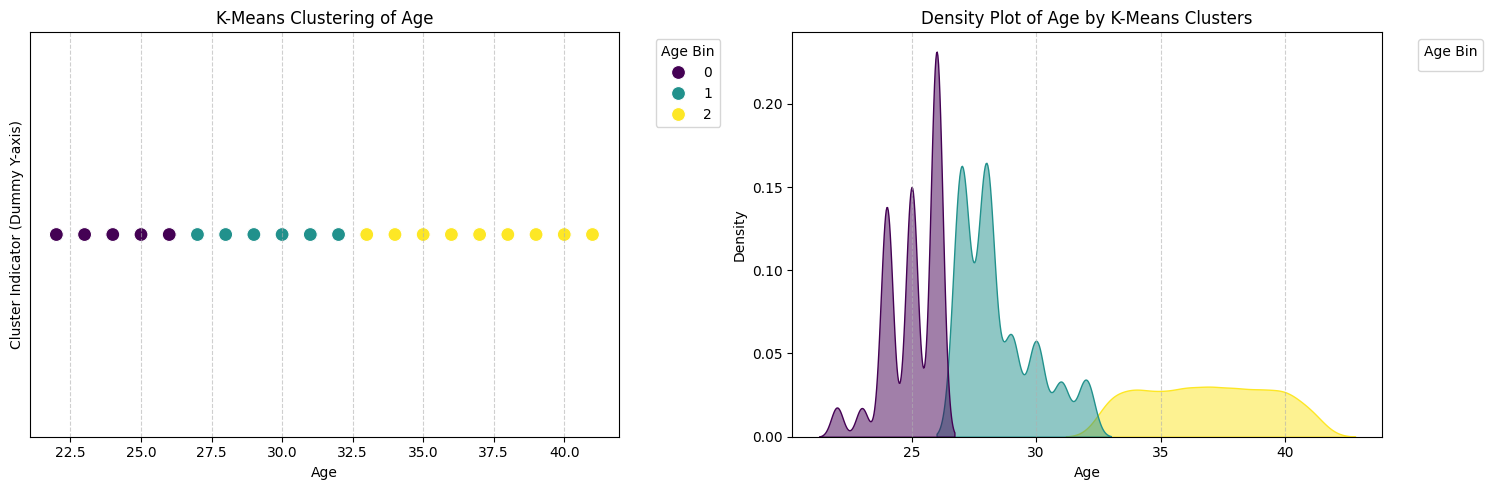

In [80]:
# Create Scatter and density plots for visualizing the clusters created.
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter Plot
sns.scatterplot(
    data=df, x='Age', y=np.zeros_like(df['Age']), hue='Age_Bin', 
    palette='viridis', s=100, ax=axes[0]
)
axes[0].set_title('K-Means Clustering of Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Cluster Indicator (Dummy Y-axis)')
axes[0].set_yticks([])  # Remove Y-axis ticks for clarity
axes[0].legend(title='Age Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(axis='x', linestyle='--', alpha=0.6)

# Density Plot
sns.kdeplot(
    data=df, x='Age', hue='Age_Bin', palette='viridis', 
    fill=True, alpha=0.5, ax=axes[1]
)
axes[1].set_title('Density Plot of Age by K-Means Clusters')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Density')
axes[1].legend(title='Age Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

# Adjust layout and show
plt.tight_layout()
plt.show()

In [81]:
# Droping Age Feature
df = df.drop(columns=['Age'])
# Renaming Age_Bin to Age
df.rename(columns={'Age_Bin': 'Age'}, inplace=True)

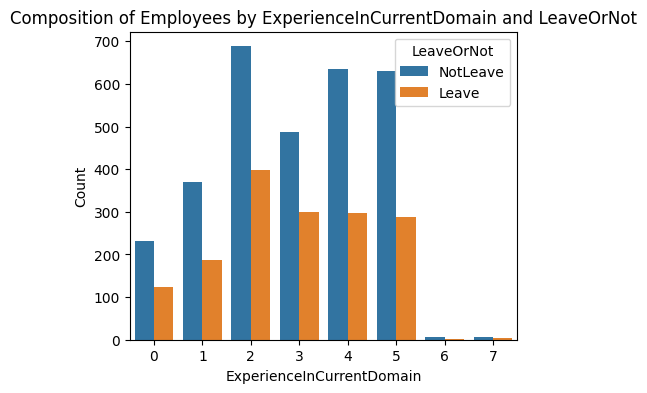

In [82]:
# Analysis of "ExperienceInCurrentDomain" Feature variable encoding technique

# Two way frequency tab
df_twoway = pd.crosstab(index=df['ExperienceInCurrentDomain'], columns=df['LeaveOrNot'], margins=False).reset_index()
df_twoway = df_twoway.rename(columns={0: 'NotLeave', 1: 'Leave'})

# Reshape the twoway DataFrame
df_experienceInCurrentDomain = pd.melt(df_twoway, id_vars="ExperienceInCurrentDomain", var_name="LeaveOrNot", value_name="Count")

plt.figure(figsize=(5, 4))
sns.barplot(x='ExperienceInCurrentDomain', y='Count', hue='LeaveOrNot', data=df_experienceInCurrentDomain)
plt.ylabel("Count")
plt.title("Composition of Employees by ExperienceInCurrentDomain and LeaveOrNot")
plt.show()

***Note:** Since the **ExperienceInCurrentDomain** shows no direct significant relationship with the target variable, we specifically apply **Kmeans clustering** for discretizing group ExperienceInCurrentDomain into **3 bins**. This helps reduce potential noise and improve the model's ability to generalize, especially when age doesn't provide additional predictive value directly.*

In [83]:
# Number of bins (clusters)
n_bins = 3  # Change this based on your requirements

# Reshape the feature to 2D array for KMeans
age_reshaped = np.array(df['ExperienceInCurrentDomain']).reshape(-1, 1)

# Apply K-Means
kmeans = KMeans(n_clusters=n_bins, random_state=42)
df['ExperienceInCurrentDomain_Bin'] = kmeans.fit_predict(age_reshaped)

# Sort bins by the cluster centers for better interpretability
bin_centers = kmeans.cluster_centers_.flatten()
sorted_bins = np.argsort(bin_centers)

# Map sorted bin indices to the original bin values
bin_mapping = {original: sorted_idx for sorted_idx, original in enumerate(sorted_bins)}
df['ExperienceInCurrentDomain_Bin'] = df['ExperienceInCurrentDomain_Bin'].map(bin_mapping)

C:\Users\SEAN\AppData\Local\Temp\ipykernel_12588\1903219915.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(title='ExperienceInCurrentDomain Bin', bbox_to_anchor=(1.05, 1), loc='upper left')


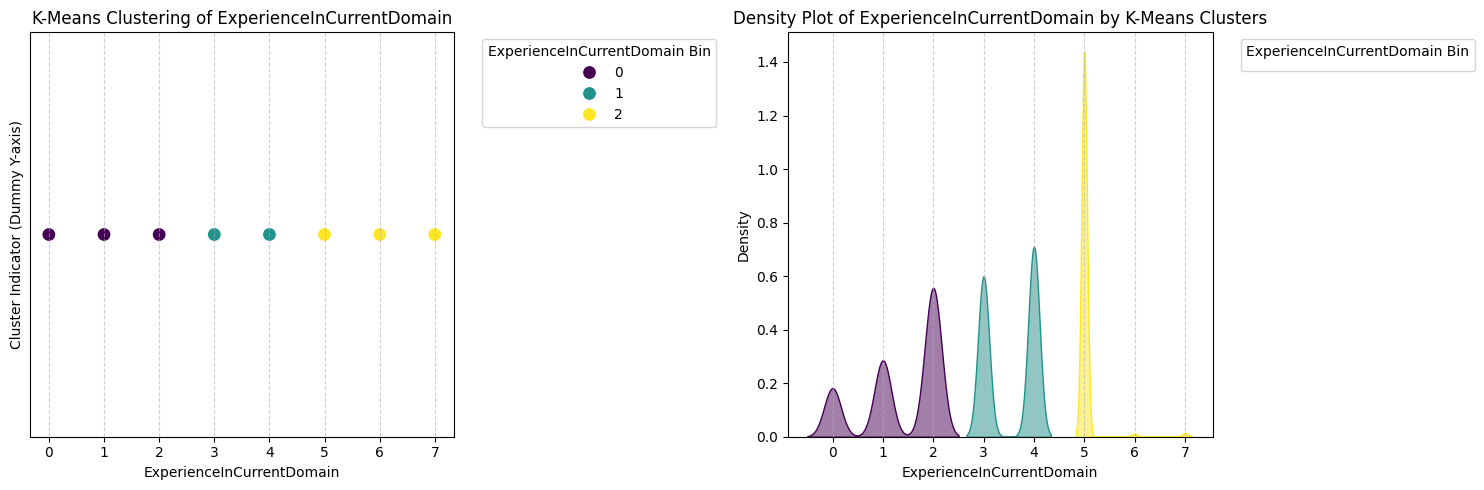

In [84]:
# Create Scatter and density plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter Plot
sns.scatterplot(
    data=df, x='ExperienceInCurrentDomain', y=np.zeros_like(df['ExperienceInCurrentDomain']), hue='ExperienceInCurrentDomain_Bin', 
    palette='viridis', s=100, ax=axes[0]
)
axes[0].set_title('K-Means Clustering of ExperienceInCurrentDomain')
axes[0].set_xlabel('ExperienceInCurrentDomain')
axes[0].set_ylabel('Cluster Indicator (Dummy Y-axis)')
axes[0].set_yticks([])  # Remove Y-axis ticks for clarity
axes[0].legend(title='ExperienceInCurrentDomain Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(axis='x', linestyle='--', alpha=0.6)

# Density Plot
sns.kdeplot(
    data=df, x='ExperienceInCurrentDomain', hue='ExperienceInCurrentDomain_Bin', palette='viridis', 
    fill=True, alpha=0.5, ax=axes[1]
)
axes[1].set_title('Density Plot of ExperienceInCurrentDomain by K-Means Clusters')
axes[1].set_xlabel('ExperienceInCurrentDomain')
axes[1].set_ylabel('Density')
axes[1].legend(title='ExperienceInCurrentDomain Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

# Adjust layout and show
plt.tight_layout()
plt.show()

In [85]:
# Droping ExperienceInCurrentDomain Feature
df = df.drop(columns=['ExperienceInCurrentDomain'])
# Renaming ExperienceInCurrentDomain_Bin to ExperienceInCurrentDomain
df.rename(columns={'ExperienceInCurrentDomain_Bin': 'ExperienceInCurrentDomain'}, inplace=True)

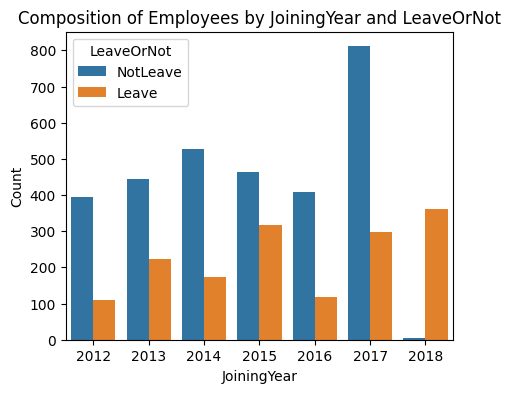

In [86]:
# Analysis of "JoiningYear" Feature variable encoding technique

# Two way frequency tab'
df_twoway = pd.crosstab(index=df['JoiningYear'], columns=df['LeaveOrNot'], margins=False).reset_index()
df_twoway = df_twoway.rename(columns={0: 'NotLeave', 1: 'Leave'})

# Reshape the twoway DataFrame
df_JoiningYear = pd.melt(df_twoway, id_vars="JoiningYear", var_name="LeaveOrNot", value_name="Count")

plt.figure(figsize=(5, 4))
sns.barplot(x='JoiningYear', y='Count', hue='LeaveOrNot', data=df_JoiningYear)
plt.ylabel("Count")
plt.title("Composition of Employees by JoiningYear and LeaveOrNot")
plt.show()

In [87]:
# Feature Engineering: Calculate Tenure
df['Tenure'] = 2024 - df['JoiningYear']
# Droping JoiningYear Feature
df = df.drop(columns=['JoiningYear'])

> ***Note:** Since the **JoiningYear** feature reflects distinct groups of employees based on their tenure with the company, we calculate the **Tenure** (years since joining). This allows the model to capture the relationship between tenure and the target variable (According to the data the employees with the low tenure are likely to leave), as tenure may influence the likelihood of an employee leaving rather than considering JoiningYear as a feature*

### **Step 4: Data Scaling (Standadization/Normalization(Min-Max))**

In [88]:
# Viewing the first few rows of the Data
df.head()

,Education,PaymentTier,Gender,EverBenched,LeaveOrNot,City_Bangalore,City_New Delhi,City_Pune,Age,ExperienceInCurrentDomain,Tenure
0,-1,3,-1,-1,0,1.0,0.0,0.0,2,0,7
1,-1,1,0,-1,1,0.0,0.0,1.0,1,1,11
2,-1,3,0,-1,0,0.0,1.0,0.0,2,0,10
3,0,3,-1,-1,1,1.0,0.0,0.0,1,2,8
4,0,3,-1,0,1,0.0,0.0,1.0,0,0,7


> ***Note:** Since the dataset does not contain features with long ranges or large values, I have plan to skip the scaling. This indeed helps to avoid unnecessary transformations, preserving the natural distribution of the data. It also allows the model to learn the relationships without distortion, leading to more efficient training and improved interpretability.*

### **Step 5: Model building and Evaluation**

In [97]:
# Convert DataFrame to Tensor
X = torch.tensor(df.drop(columns=['LeaveOrNot']).values, dtype=torch.float32)
y = torch.tensor(df['LeaveOrNot'].values, dtype=torch.float32)

# Split into Train, Validation, and Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"No of Data in X_train: {X_train.shape[0]}")
print(f"No of Data in X_val: {X_val.shape[0]}")
print(f"No of Data in X_test: {X_test.shape[0]}")

# Use TensorDataset to create datasets
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

No of Data in X_train: 3257
No of Data in X_val: 698
No of Data in X_test: 698


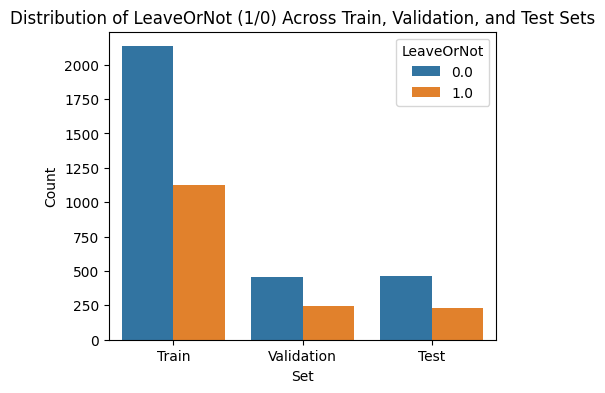

In [91]:
# Convert target tensors to Pandas DataFrames for plotting
train_df = pd.DataFrame({'Set': 'Train', 'LeaveOrNot': y_train.numpy()})
val_df = pd.DataFrame({'Set': 'Validation', 'LeaveOrNot': y_val.numpy()})
test_df = pd.DataFrame({'Set': 'Test', 'LeaveOrNot': y_test.numpy()})

# Concatenate all sets into one DataFrame
combined_df = pd.concat([train_df, val_df, test_df])

# Create the count plot
plt.figure(figsize=(5, 4))
sns.countplot(data=combined_df, x='Set', hue='LeaveOrNot')
plt.title('Distribution of LeaveOrNot (1/0) Across Train, Validation, and Test Sets')
plt.xlabel('Set')
plt.ylabel('Count')
plt.legend(title='LeaveOrNot')
plt.show()

> ***Note:** The sampled **Training, Validation, and Testing datasets** have **equal proportions** of the **"leave" and "not leave"** classes. This balanced sampling helps the model learn to predict both outcomes effectively, improving its ability to generalize and reducing the risk of bias towards one class.*

In [92]:
# Create DataLoaders for training, validation, and testing datasets with the desired batch_size
def create_data_loaders(train_data, val_data, test_data, batch_size):
    """
    Create DataLoaders for training, validation, and testing datasets.

    Args:
        train_data (Dataset): Training dataset.
        val_data (Dataset): Validation dataset.
        test_data (Dataset): Testing dataset.
        batch_size (int): Batch size for the DataLoaders.

    Returns:
        tuple: DataLoaders for training, validation, and testing.
    """
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

In [93]:
# Define the dynamic MLP model
class DynamicMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation_fn, init_mode):
        """
        Args:
            input_dim (int): Number of input features.
            hidden_layers (list): List containing the number of neurons in each hidden layer.
            activation_fn (str): Activation function to use ('relu', 'selu', etc.).
            init_mode (str): Weight initialization mode ('kaiming', 'xavier').
        """
        super(DynamicMLP, self).__init__()
        
        self.layers = nn.ModuleList()
        
        # Define activation function
        activations = {
            'relu': nn.ReLU(),
            'selu': nn.SELU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU()
        }
        self.activation_fn = activations.get(activation_fn.lower(), nn.ReLU())

        # Input layer
        prev_dim = input_dim
        for neurons in hidden_layers:
            self.layers.append(nn.Linear(prev_dim, neurons))
            prev_dim = neurons

        # Output layer
        self.output_layer = nn.Linear(prev_dim, 1)
        self.sigmoid = nn.Sigmoid()

        # Initialize weights
        self.init_weights(init_mode)

    def init_weights(self, mode):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if mode == 'kaiming':
                    torch.nn.init.kaiming_uniform_(layer.weight, mode='fan_in')
                elif mode == 'xavier':
                    torch.nn.init.xavier_uniform_(layer.weight)

        if mode == 'kaiming':
            torch.nn.init.kaiming_uniform_(self.output_layer.weight, mode='fan_in')
        elif mode == 'xavier':
            torch.nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        for layer in self.layers:
            x = self.activation_fn(layer(x))
        x = self.sigmoid(self.output_layer(x))
        return x

In [127]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    """
    Train the model for a specified number of epochs.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion: Loss function.
        optimizer: Optimizer for model training.
        num_epochs (int): Number of epochs to train.

    Returns:
        dict: Contains training and validation losses and accuracies for each epoch.
    """
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for X_batch, y_batch in train_loader:
            y_batch = y_batch.view(-1, 1)  # Reshape target to match model output
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_batch = y_batch.view(-1, 1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct_val += (predicted == y_batch).sum().item()
                total_val += y_batch.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        # Log Epoch Metrics
        print(f"Epoch {epoch+1}/{num_epochs}, {colored('Train Loss:', 'red')} {train_losses[-1]:.4f} | {colored('Train Accuracy:', 'yellow')} {train_accuracies[-1]:.4f}, {colored('Validation Loss:', 'red')} {val_losses[-1]:.4f} | {colored('Validation Accuracy:', 'yellow')} {val_accuracies[-1]:.4f}")
        print('-' * 50)

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

In [95]:
def get_optimizer(optimizer_name, model, learning_rate):
    """
    Returns the optimizer based on the specified name.

    Args:
        optimizer_name (str): Name of the optimizer ('adam', 'sgd', 'rmsprop', 'adamw', 'adagrad').
        model (nn.Module): The PyTorch model whose parameters the optimizer will update.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        torch.optim.Optimizer: Configured optimizer.
    """
    if optimizer_name.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name.lower() == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'adamw':
        return optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizer_name.lower() == 'adagrad':
        return optim.Adagrad(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

In [119]:
def run_experiment(config, train_data, val_data, test_data):
    """
    Runs the experiment based on the given configuration.

    Args:
        config (dict): Configuration dictionary with keys:
            - 'input_dim': Dimension of input features.
            - 'learning_rate': Learning rate for the optimizer.
            - 'batch_size': Batch size for data loaders.
            - 'hidden_layers': List defining the number of neurons in each hidden layer.
            - 'activation_fn': Activation function ('relu', 'selu', etc.).
            - 'init_mode': Weight initialization mode ('kaiming', 'xavier', etc.).
            - 'num_epochs': Number of epochs for training.
            - 'optimizer_name': Name of the optimizer ('adam', 'sgd', etc.).
        train_data (Dataset): Training dataset.
        val_data (Dataset): Validation dataset.
        test_data (Dataset): Testing dataset.

    Returns:
        dict: Metrics including training and validation losses and accuracies.
    """

    print(colored("==== Start of Experiment ====", 'green', attrs=['bold']))
    print("-" * 50)
    
    # Data Loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        train_data, val_data, test_data, config['batch_size']
    )

    # Initialize Model
    model = DynamicMLP(
        input_dim=config['input_dim'],
        hidden_layers=config['hidden_layers'],
        activation_fn=config['activation_fn'],
        init_mode=config['init_mode']
    )
    
    print(colored("Model Architecture:", 'blue', attrs=['bold']))
    print(model)
    print("=" * 50)

    # Define Loss Function and Optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = get_optimizer(config['optimizer_name'], model, config['learning_rate'])

    # Train the Model
    metrics = train_model(model, train_loader, val_loader, criterion, optimizer, config['num_epochs'])

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate the Model on Test Data
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_batch = y_batch.view(-1, 1)  # Reshape target
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct_test += (predicted == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_loss /= len(test_loader)
    test_accuracy = correct_test / total_test

    print(colored("==== Experiment Summary ====", 'green', attrs=['bold']))
    print(f"  {colored('Test Loss:', 'magenta')} {test_loss:.4f} | {colored('Test Accuracy:', 'magenta')} {test_accuracy:.4f}")
    print("=" * 50)

#### **Experiment 01**

==== Start of Experiment ====
--------------------------------------------------
Model Architecture:
DynamicMLP(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=2, bias=True)
  )
  (activation_fn): ReLU()
  (output_layer): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1/50, Train Loss: 0.6471 | Train Accuracy: 0.6540, Validation Loss: 0.6502 | Validation Accuracy: 0.6504
--------------------------------------------------
Epoch 2/50, Train Loss: 0.6449 | Train Accuracy: 0.6549, Validation Loss: 0.6491 | Validation Accuracy: 0.6504
--------------------------------------------------
Epoch 3/50, Train Loss: 0.6452 | Train Accuracy: 0.6549, Validation Loss: 0.6480 | Validation Accuracy: 0.6504
--------------------------------------------------
Epoch 4/50, Train Loss: 0.6449 | Train Accuracy: 0.6549, Validation Loss: 0.6489 | Validation Accuracy: 0.6504
---------------------------

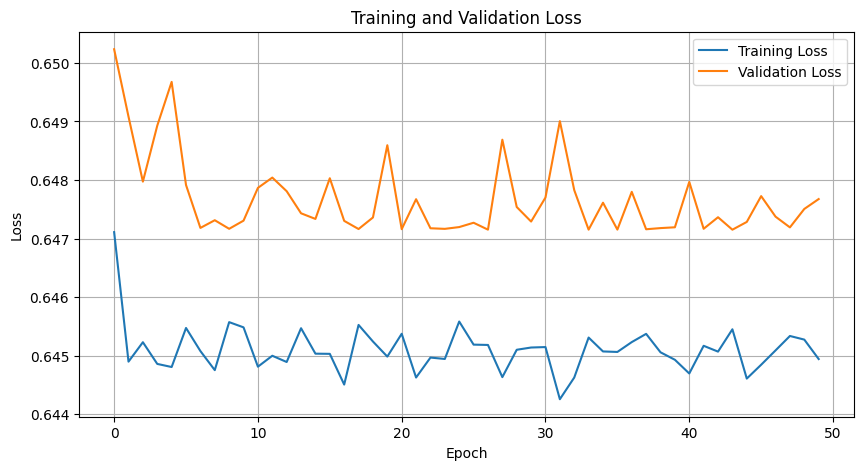

==== Experiment Summary ====
  Test Loss: 0.6365 | Test Accuracy: 0.6676


In [123]:
config = {
    'input_dim': X_train.shape[1],
    'batch_size': 5,
    'hidden_layers': [4, 2],
    'activation_fn': 'relu',
    'init_mode': 'xavier',
    'optimizer_name': 'rmsprop',
    'learning_rate': 0.01,
    'num_epochs': 50
}
run_experiment(config, train_data, val_data, test_data)

> ***Note:** In this experiment, the model exhibited **minimal improvement in both training and validation loss**, with training accuracy stagnating at around **65.49%** and validation accuracy consistently at **65.04%** throughout the 50 epochs. This suggests that the model **failed to effectively learn** from the data, possibly due to an insufficient network architecture or learning rate. Despite using Xavier initialization and the RMSprop optimizer, the model did not show significant progress, indicating that either the model's complexity (with only two hidden layers) was too simple for the problem or that the chosen hyperparameters, like the learning rate, may not have been optimal. The test accuracy of 66.76% further supports this, highlighting that the model struggled to generalize well to unseen data.*

#### **Experiment 02**

==== Start of Experiment ====
--------------------------------------------------
Model Architecture:
DynamicMLP(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=4, bias=True)
  )
  (activation_fn): ReLU()
  (output_layer): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1/50, Train Loss: 0.6147 | Train Accuracy: 0.6890, Validation Loss: 0.5478 | Validation Accuracy: 0.7579
--------------------------------------------------
Epoch 2/50, Train Loss: 0.5605 | Train Accuracy: 0.7375, Validation Loss: 0.5212 | Validation Accuracy: 0.7564
--------------------------------------------------
Epoch 3/50, Train Loss: 0.5434 | Train Accuracy: 0.7409, Validation Loss: 0.5067 | Validation Accuracy: 0.7722
--------------------------------------------------
Epoch 4/50, Train Loss: 0.5352 | Train Accuracy: 0.7513, Validation Loss: 0.4901 | Validation Accuracy: 0.7966
---------------------------

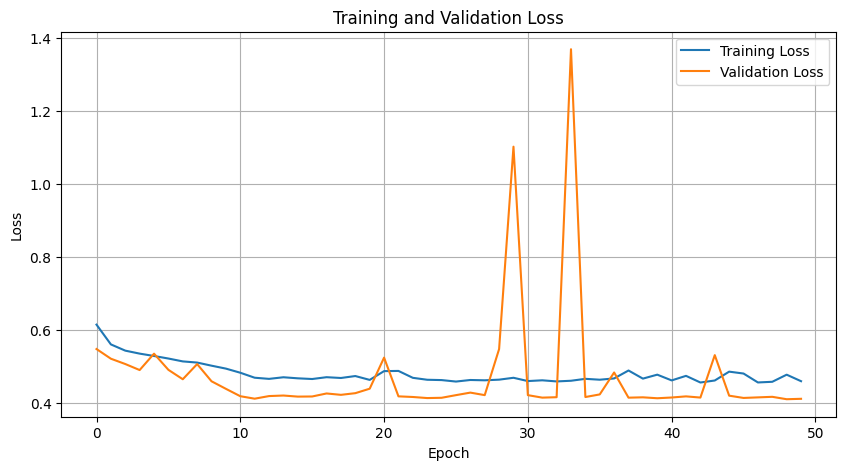

==== Experiment Summary ====
  Test Loss: 0.4317 | Test Accuracy: 0.8252


In [124]:
config = {
    'input_dim': X_train.shape[1],
    'batch_size': 5,
    'hidden_layers': [8, 4],
    'activation_fn': 'relu',
    'init_mode': 'xavier',
    'optimizer_name': 'rmsprop',
    'learning_rate': 0.01,
    'num_epochs': 50
}
run_experiment(config, train_data, val_data, test_data)

> ***Note:** In the updated experiment, the model achieved a **test accuracy** of **82.52%**, showing an improvement compared to the previous version. The training accuracy increased steadily, reaching 81.09% by the final epoch, with validation accuracy peaking at 83.81%. However, despite these improvements, the model's validation accuracy fluctuated, indicating some instability in its generalization. The **validation loss also varied, with a few instances of significant increases**, suggesting that the **model may be prone to overfitting at certain stages**.*

#### **Experiment 03**

==== Start of Experiment ====
--------------------------------------------------
Model Architecture:
DynamicMLP(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
  )
  (activation_fn): SELU()
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1/50, Train Loss: 0.6597 | Train Accuracy: 0.6933, Validation Loss: 0.5471 | Validation Accuracy: 0.7464
--------------------------------------------------
Epoch 2/50, Train Loss: 0.5519 | Train Accuracy: 0.7446, Validation Loss: 0.4938 | Validation Accuracy: 0.8109
--------------------------------------------------
Epoch 3/50, Train Loss: 0.5164 | Train Accuracy: 0.7737, Validation Loss: 0.5112 | Validation Accuracy: 0.7679
--------------------------------------------------
Epoch 4/50, Train Loss: 0.4957 | Train Accuracy: 0.7909, Validation Loss: 0.4321 | Validation Accuracy: 0.8295
-------------------------

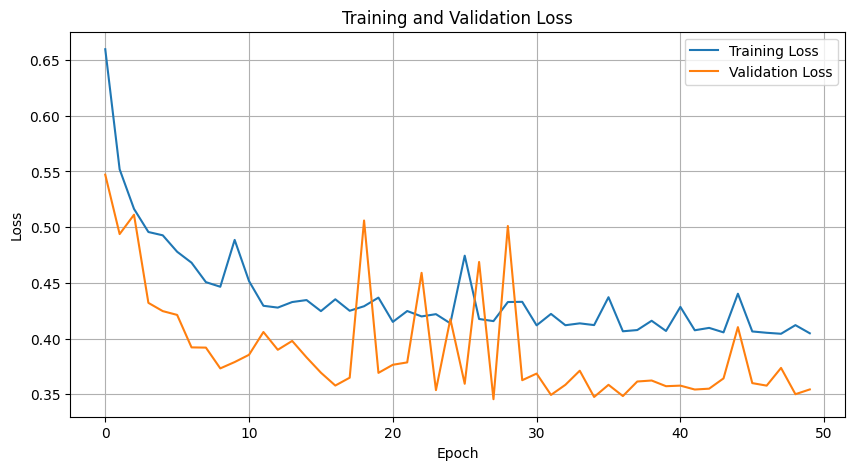

==== Experiment Summary ====
  Test Loss: 0.3967 | Test Accuracy: 0.8309


In [125]:
config = {
    'input_dim': X_train.shape[1],
    'batch_size': 32,
    'hidden_layers': [16, 8],
    'activation_fn': 'selu',
    'init_mode': 'xavier',
    'optimizer_name': 'rmsprop',
    'learning_rate': 0.01,
    'num_epochs': 50
}
run_experiment(config, train_data, val_data, test_data)

> ***Note:** In the updated experiment, the model achieved a **test accuracy of 83.09%**, showing a notable improvement compared to previous versions. The training accuracy steadily increased, reaching 82.59% by the final epoch, with validation accuracy peaking at 86.82%. However, the model's validation accuracy fluctuated throughout the epochs, especially after epoch 19 and around epoch 29, indicating some instability in its generalization. The validation loss varied, with instances of increases, particularly in later epochs, suggesting that the model may be prone to overfitting as it progressed. While the SELU activation function and Xavier initialization seemed to aid in smoother training and faster convergence, the model still shows signs of overfitting, particularly due to its complexity and the potential mismatch between model size and dataset characteristics.*

#### **Experiment 04**

==== Start of Experiment ====
--------------------------------------------------
Model Architecture:
DynamicMLP(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
  )
  (activation_fn): SELU()
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1/50, Train Loss: 2.0428 | Train Accuracy: 0.4529, Validation Loss: 0.8193 | Validation Accuracy: 0.5516
--------------------------------------------------
Epoch 2/50, Train Loss: 0.7740 | Train Accuracy: 0.5576, Validation Loss: 0.6829 | Validation Accuracy: 0.6089
--------------------------------------------------
Epoch 3/50, Train Loss: 0.6699 | Train Accuracy: 0.6319, Validation Loss: 0.6291 | Validation Accuracy: 0.6605
--------------------------------------------------
Epoch 4/50, Train Loss: 0.6097 | Train Accuracy: 0.6782, Validation Loss: 0.5766 | Validation Accuracy: 0.7292
-------------------------

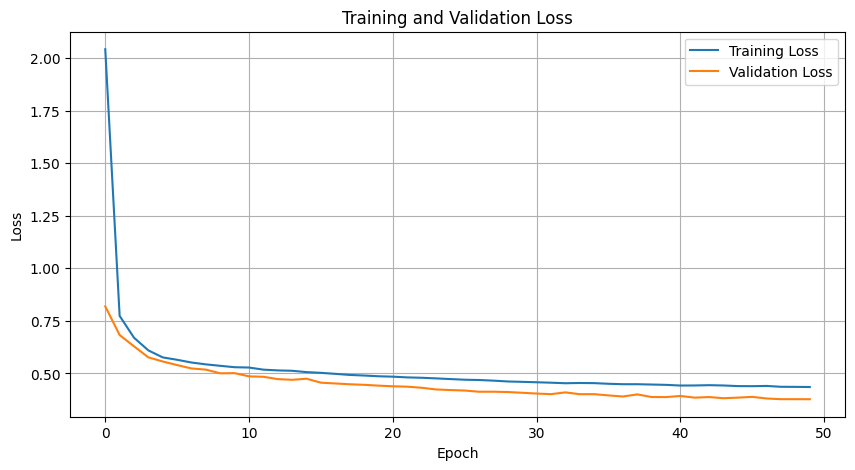

==== Experiment Summary ====
  Test Loss: 0.4187 | Test Accuracy: 0.8152


In [128]:
config = {
    'input_dim': X_train.shape[1],
    'batch_size': 32,
    'hidden_layers': [16, 8],
    'activation_fn': 'selu',
    'init_mode': 'kaiming',
    'optimizer_name': 'adam',
    'learning_rate': 0.001,
    'num_epochs': 50
}
run_experiment(config, train_data, val_data, test_data)

> ***Note:** In the updated experiment, the model achieved a test accuracy of **81.52%**, reflecting steady improvement throughout training. Training accuracy consistently increased, peaking at 81.52% by the final epoch, while validation accuracy reached a high of 85.39%. The **SELU activation function paired with Kaiming initialization enhanced convergence and training stability compared to earlier runs**. **Validation accuracy showed less fluctuation, especially in later epochs**, **indicating better generalization**. However, occasional increases in validation loss suggest mild overfitting tendencies, particularly in the final epochs. With a structured architecture using two hidden layers and the Adam optimizer, the model effectively leveraged the learning rate of 0.001 for smooth optimization, achieving improved performance over previous configurations.*

#### **Futhur analizing the Experiment 04 model using (Precision, Recall)**

Epoch 1/50, Train Loss: 0.8245 | Train Accuracy: 0.5788, Validation Loss: 0.6055 | Validation Accuracy: 0.6777
--------------------------------------------------
Epoch 2/50, Train Loss: 0.6110 | Train Accuracy: 0.6853, Validation Loss: 0.5837 | Validation Accuracy: 0.7163
--------------------------------------------------
Epoch 3/50, Train Loss: 0.5922 | Train Accuracy: 0.7074, Validation Loss: 0.5626 | Validation Accuracy: 0.7464
--------------------------------------------------
Epoch 4/50, Train Loss: 0.5747 | Train Accuracy: 0.7228, Validation Loss: 0.5462 | Validation Accuracy: 0.7206
--------------------------------------------------
Epoch 5/50, Train Loss: 0.5598 | Train Accuracy: 0.7406, Validation Loss: 0.5292 | Validation Accuracy: 0.7751
--------------------------------------------------
Epoch 6/50, Train Loss: 0.5503 | Train Accuracy: 0.7544, Validation Loss: 0.5172 | Validation Accuracy: 0.7894
--------------------------------------------------
Epoch 7/50, Train Loss: 0.54

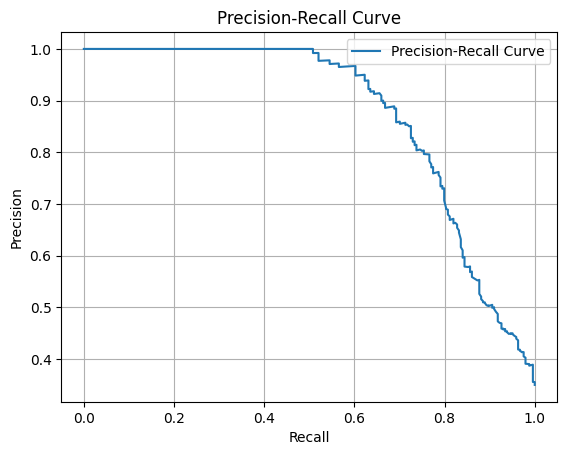

PR AUC: 0.8723004919789743


In [137]:
config = {
    'input_dim': X_train.shape[1],
    'batch_size': 32,
    'hidden_layers': [16, 8],
    'activation_fn': 'selu',
    'init_mode': 'kaiming',
    'optimizer_name': 'adam',
    'learning_rate': 0.001,
    'num_epochs': 50
}
model = DynamicMLP(
        input_dim=config['input_dim'],
        hidden_layers=config['hidden_layers'],
        activation_fn=config['activation_fn'],
        init_mode=config['init_mode']
    )

# Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = get_optimizer(config['optimizer_name'], model, config['learning_rate'])

# Data Loaders
train_loader, val_loader, test_loader = create_data_loaders(
    train_data, val_data, test_data, config['batch_size']
)

# Train the Model
train_model(model, train_loader, val_loader, criterion, optimizer, config['num_epochs'])

# Switch model to evaluation mode
model.eval()

true_labels = []
predicted_probs = []

with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        outputs = model(inputs)
        predicted_probs.extend(outputs.squeeze().tolist())
        true_labels.extend(labels.tolist())

threshold = 0.5
predicted_labels = [1 if prob >= threshold else 0 for prob in predicted_probs]

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Classification Report
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(classification_report(true_labels, predicted_labels))

# Precision-Recall Curve
precision_vals, recall_vals, thresholds = precision_recall_curve(true_labels, predicted_probs)
plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# PR AUC
pr_auc = auc(recall_vals, precision_vals)
print(f"PR AUC: {pr_auc}")